In [5]:
from maf import persistence
import pandas as pd
from maf.core import PositionState
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(24)

In [6]:
def load_experiment_data(experiment_dir: str, logger: str) -> list[dict]:
    data: list[dict] = []
    for log_file in persistence.list_files(experiment_dir, logger):
        data.append(persistence.load(experiment_dir, logger, log_file))
    return data

## PositionLogger

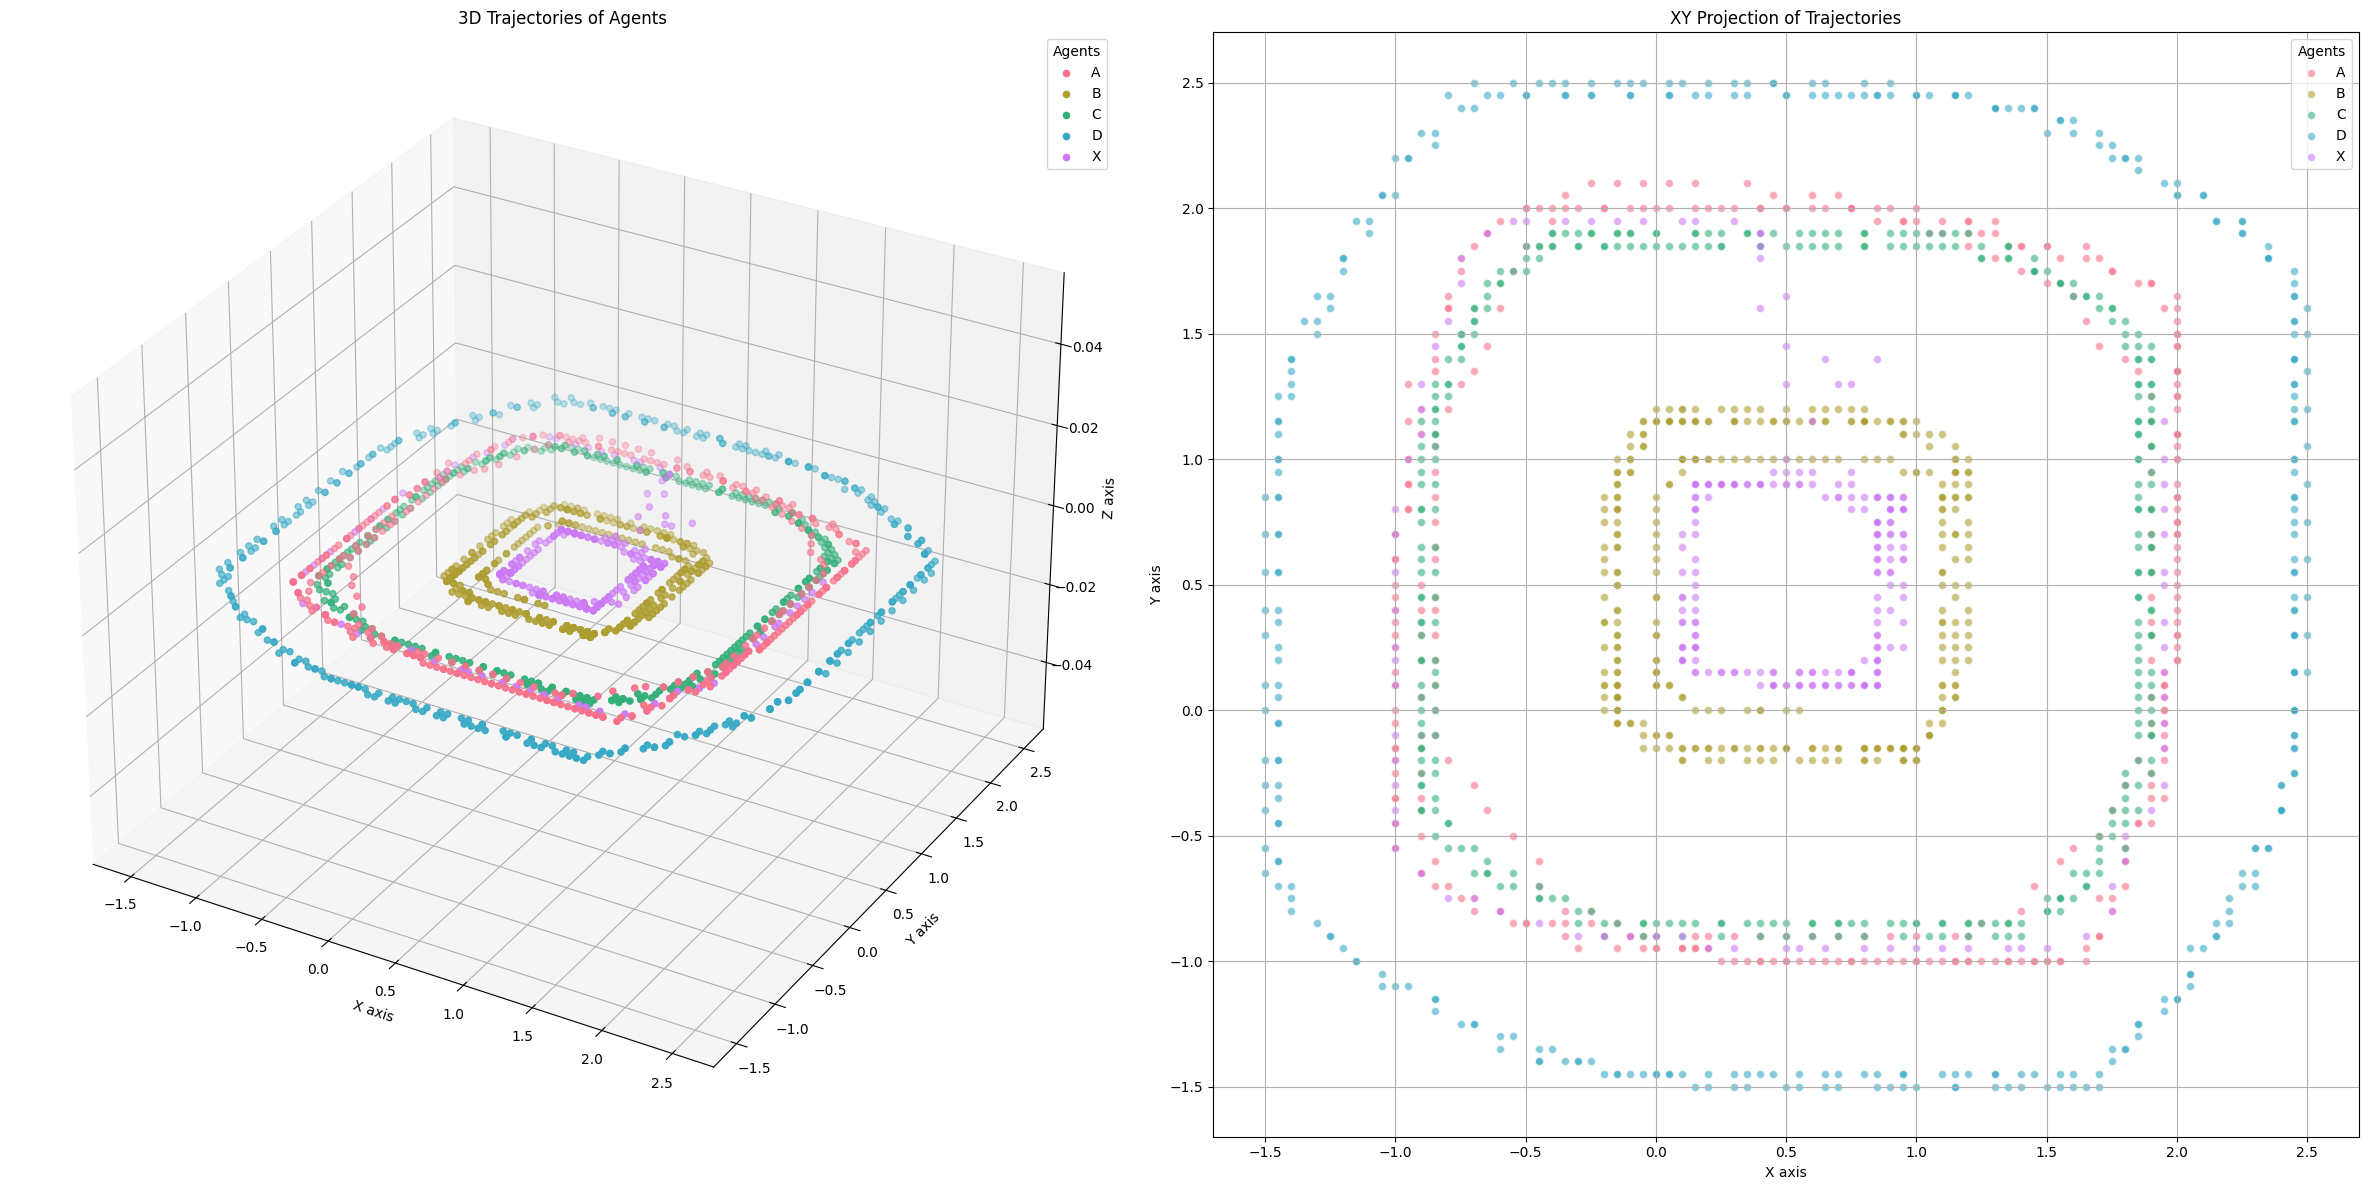

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import ndarray


def generate_colors(df: pd.DataFrame) -> dict[str, ndarray]:
    unique_agents: list[str] = df["agent"].unique()
    # Use seaborn color palette
    palette = sns.color_palette("husl", len(unique_agents))
    colors: dict[str, ndarray] = {
        agent: palette[i] for i, agent in enumerate(sorted(unique_agents))
    }
    return colors


def plot_3d_trajectories(ax, df: pd.DataFrame, colors: dict[str, ndarray]):
    assert set(df.columns) == {"agent", "X", "Y", "Z"}, "Invalid df provided"

    for agent, group in df.groupby("agent"):
        ax.scatter(group["X"], group["Y"], group["Z"], color=colors[agent], label=agent)

    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    ax.set_title("3D Trajectories of Agents")
    ax.legend(title="Agents")


def scatter_xy_trajectories(ax, df: pd.DataFrame, colors: dict[str, ndarray]):
    assert set(df.columns) == {"agent", "X", "Y", "Z"}, "Invalid df provided"

    for agent, group in df.groupby("agent"):
        ax.scatter(
            group["X"],
            group["Y"],
            color=colors[agent],
            label=agent,
            alpha=0.6,
            edgecolors="w",
        )

    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_title("XY Projection of Trajectories")
    ax.legend(title="Agents")
    ax.grid(True)


def plot_trajectories(df: pd.DataFrame):
    colors = generate_colors(df)

    fig = plt.figure(figsize=(24, 12))

    # Create 3D subplot
    ax1 = fig.add_subplot(121, projection="3d")
    plot_3d_trajectories(ax1, df, colors)

    # Create 2D subplot for XY plane
    ax2 = fig.add_subplot(122)
    scatter_xy_trajectories(ax2, df, colors)

    plt.tight_layout()
    plt.show()


def plot_experiment_trajectories(experiment: str):
    processed_data: list[dict] = []
    for data_log in load_experiment_data(experiment, "PositionLogger"):
        state: PositionState = data_log["state"]
        processed_data.append(
            {
                "agent": data_log["agent"],
                "X": state.position.x,
                "Y": state.position.y,
                "Z": state.position.z,
            }
        )

    df: pd.DataFrame = pd.DataFrame(
        processed_data, columns=["agent", "X", "Y", "Z"]
    ).fillna(0)
    plot_trajectories(df)

plot_experiment_trajectories('hill_climbing_square')

KeyError: '__fields_set__'

## Field modulation

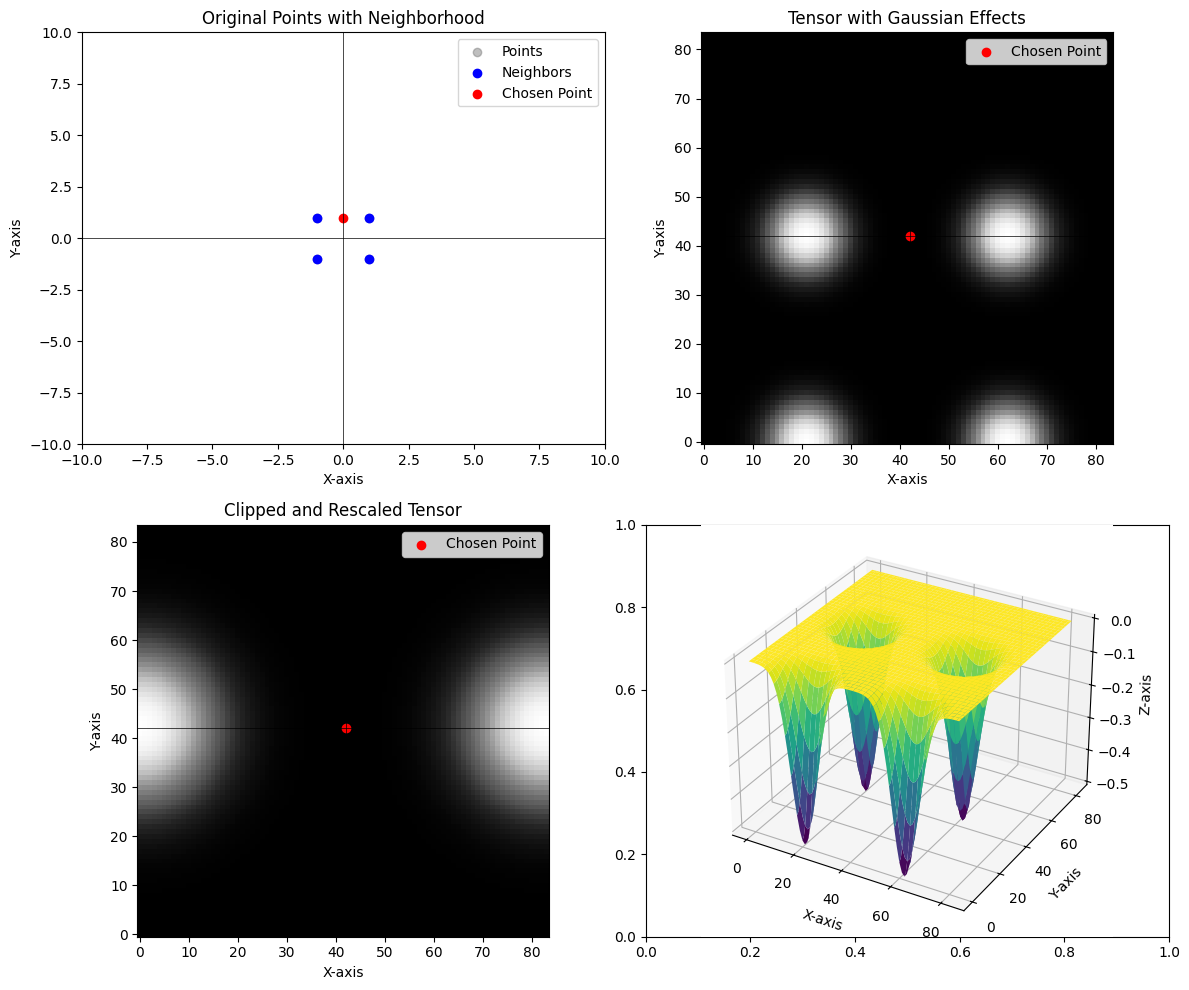

In [13]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
from mpl_toolkits.mplot3d import Axes3D

# Parameters
vicinity_limit = [2, 2]  # The vicinity limit around the chosen point (x, y)
tensor_size = [84, 84]  # The size of the final tensor (height, width)
sigma_scale = 5  # Scale for the Gaussian sigma relative to the initial space unit
negative_value = -1  # Value to fill the tensor edges

# Step 1: Generate random points
num_points = 1000
points = np.random.uniform(-100, 100, size=(num_points, 2))

points = np.array([[1, 1], [-1, -1], [-1, 1], [1, -1]])
# Step 2: Choose a random center point
center_point = [0, 1]

# Step 3: Find neighboring points within the box limit of ±vicinity_limit
x_min, x_max = center_point[0] - vicinity_limit[0], center_point[0] + vicinity_limit[0]
y_min, y_max = center_point[1] - vicinity_limit[1], center_point[1] + vicinity_limit[1]

neighbors = points[
    (points[:, 0] >= x_min)
    & (points[:, 0] <= x_max)
    & (points[:, 1] >= y_min)
    & (points[:, 1] <= y_max)
]

INITIAL_VALUE_TENSOR = 0
# Step 4: Project the points onto a centered torch.Tensor of shape (tensor_size[0], tensor_size[1])
tensor = torch.full(
    (tensor_size[0], tensor_size[1]), INITIAL_VALUE_TENSOR, dtype=torch.float32
)


# Normalize points to the centered tensor space
def to_tensor_space(point, center_point, tensor_size, vicinity_limit):
    x, y = point
    cx, cy = center_point
    # Normalize to [0, 1] range first
    x_normalized = (x - (cx - vicinity_limit[0])) / (2 * vicinity_limit[0])
    y_normalized = (y - (cy - vicinity_limit[1])) / (2 * vicinity_limit[1])
    # Convert to tensor space indices
    x_tensor = int(round(x_normalized * (tensor_size[1] - 1)))
    y_tensor = int(round(y_normalized * (tensor_size[0] - 1)))
    # Clamp indices to ensure they are within bounds
    x_tensor = np.clip(x_tensor, 0, tensor_size[1] - 1)
    y_tensor = np.clip(y_tensor, 0, tensor_size[0] - 1)
    return x_tensor, y_tensor


# Apply Gaussian distribution around each neighboring point on the tensor
def apply_distribution(field, position, sigma=10, amplitude=0.2, operation="add"):
    x, y = position
    grid_x, grid_y = np.meshgrid(
        np.arange(field.shape[1]), np.arange(field.shape[0]), indexing="ij"
    )
    gaussian = amplitude * np.exp(
        -((grid_x - x) ** 2 + (grid_y - y) ** 2) / (2 * sigma**2)
    )

    if operation == "add":
        return field + torch.tensor(gaussian, dtype=torch.float32)
    elif operation == "subtract":
        return field - torch.tensor(gaussian, dtype=torch.float32)
    elif operation == "replace":
        mask = gaussian > 0
        field[mask] = torch.tensor(gaussian[mask], dtype=torch.float32)
        return field
    else:
        raise ValueError("Invalid operation type. Use 'add', 'subtract', or 'replace'.")


# Apply Gaussian to each neighboring point, excluding the center point
for point in neighbors:
    if np.all(point == center_point):
        continue

    x_tensor, y_tensor = to_tensor_space(
        point, center_point, tensor_size, vicinity_limit
    )

    # Ensure the indices are within the bounds of the tensor
    if 0 <= x_tensor < tensor_size[1] and 0 <= y_tensor < tensor_size[0]:
        tensor = apply_distribution(
            tensor,
            (y_tensor, x_tensor),
            sigma=sigma_scale,
            amplitude=0.5,
            operation="subtract",
        )
    else:
        print(
            f"Point {point} projected to out-of-bounds tensor coordinates ({x_tensor}, {y_tensor})"
        )

# Fill tensor with the constant value outside the computed limits
limits = {
    "x_min": to_tensor_space(
        [-10, center_point[1]], center_point, tensor_size, vicinity_limit
    )[0],
    "x_max": to_tensor_space(
        [10, center_point[1]], center_point, tensor_size, vicinity_limit
    )[0],
    "y_min": to_tensor_space(
        [center_point[0], -10], center_point, tensor_size, vicinity_limit
    )[1],
    "y_max": to_tensor_space(
        [center_point[0], 10], center_point, tensor_size, vicinity_limit
    )[1],
}

tensor[:, : limits["x_min"]] = negative_value
tensor[:, limits["x_max"] + 1 :] = negative_value
tensor[: limits["y_min"], :] = negative_value
tensor[limits["y_max"] + 1 :, :] = negative_value

# Clip and resize the tensor
clip_size = [tensor_size[0] // 2, tensor_size[1] // 2]
start_x = tensor_size[1] // 2 - clip_size[1] // 2
start_y = tensor_size[0] // 2 - clip_size[0] // 2

clipped_tensor = tensor[
    start_y : start_y + clip_size[0], start_x : start_x + clip_size[1]
]
rescaled_tensor = torch.tensor(
    zoom(
        clipped_tensor.numpy(),
        (tensor_size[0] / clip_size[0], tensor_size[1] / clip_size[1]),
        order=1,
    ),
    dtype=torch.float32,
)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot the original points and the chosen point
ax[0, 0].scatter(points[:, 0], points[:, 1], color="gray", alpha=0.5, label="Points")
ax[0, 0].scatter(neighbors[:, 0], neighbors[:, 1], color="blue", label="Neighbors")
ax[0, 0].scatter(center_point[0], center_point[1], color="red", label="Chosen Point")
ax[0, 0].axhline(0, color="black", linewidth=0.5)
ax[0, 0].axvline(0, color="black", linewidth=0.5)
ax[0, 0].set_xlim(-10, 10)
ax[0, 0].set_ylim(-10, 10)
ax[0, 0].legend()
ax[0, 0].set_xlabel("X-axis")
ax[0, 0].set_ylabel("Y-axis")
ax[0, 0].set_title("Original Points with Neighborhood")

# Plot the tensor with Gaussian effects
ax[0, 1].imshow(tensor.numpy(), cmap="Greys", origin="lower")
center_x, center_y = to_tensor_space(
    center_point, center_point, tensor_size, vicinity_limit
)
ax[0, 1].scatter(center_x, center_y, color="red", label="Chosen Point")
ax[0, 1].axhline(center_y, color="black", linewidth=0.5)
ax[0, 1].axvline(center_x, color="black", linewidth=0.5)
ax[0, 1].set_xlabel("X-axis")
ax[0, 1].set_ylabel("Y-axis")
ax[0, 1].set_title("Tensor with Gaussian Effects")
ax[0, 1].legend()

# Plot the clipped and rescaled tensor
ax[1, 0].imshow(rescaled_tensor.numpy(), cmap="Greys", origin="lower")
center_x_rescaled, center_y_rescaled = tensor_size[1] // 2, tensor_size[0] // 2
ax[1, 0].scatter(
    center_x_rescaled, center_y_rescaled, color="red", label="Chosen Point"
)
ax[1, 0].axhline(center_y_rescaled, color="black", linewidth=0.5)
ax[1, 0].axvline(center_x_rescaled, color="black", linewidth=0.5)
ax[1, 0].set_xlabel("X-axis")
ax[1, 0].set_ylabel("Y-axis")
ax[1, 0].set_title("Clipped and Rescaled Tensor")
ax[1, 0].legend()

# Plot the 3D surface plot
ax_3d = fig.add_subplot(2, 2, 4, projection="3d")

# Generate x and y coordinates
x = np.arange(tensor_size[1])  # Columns
y = np.arange(tensor_size[0])  # Rows
x, y = np.meshgrid(x, y)

# Plot the surface
ax_3d.plot_surface(x, y, tensor.numpy(), cmap="viridis")

# Set labels
ax_3d.set_xlabel("X-axis")
ax_3d.set_ylabel("Y-axis")
ax_3d.set_zlabel("Z-axis")

# Show the plots
plt.tight_layout()
plt.show()

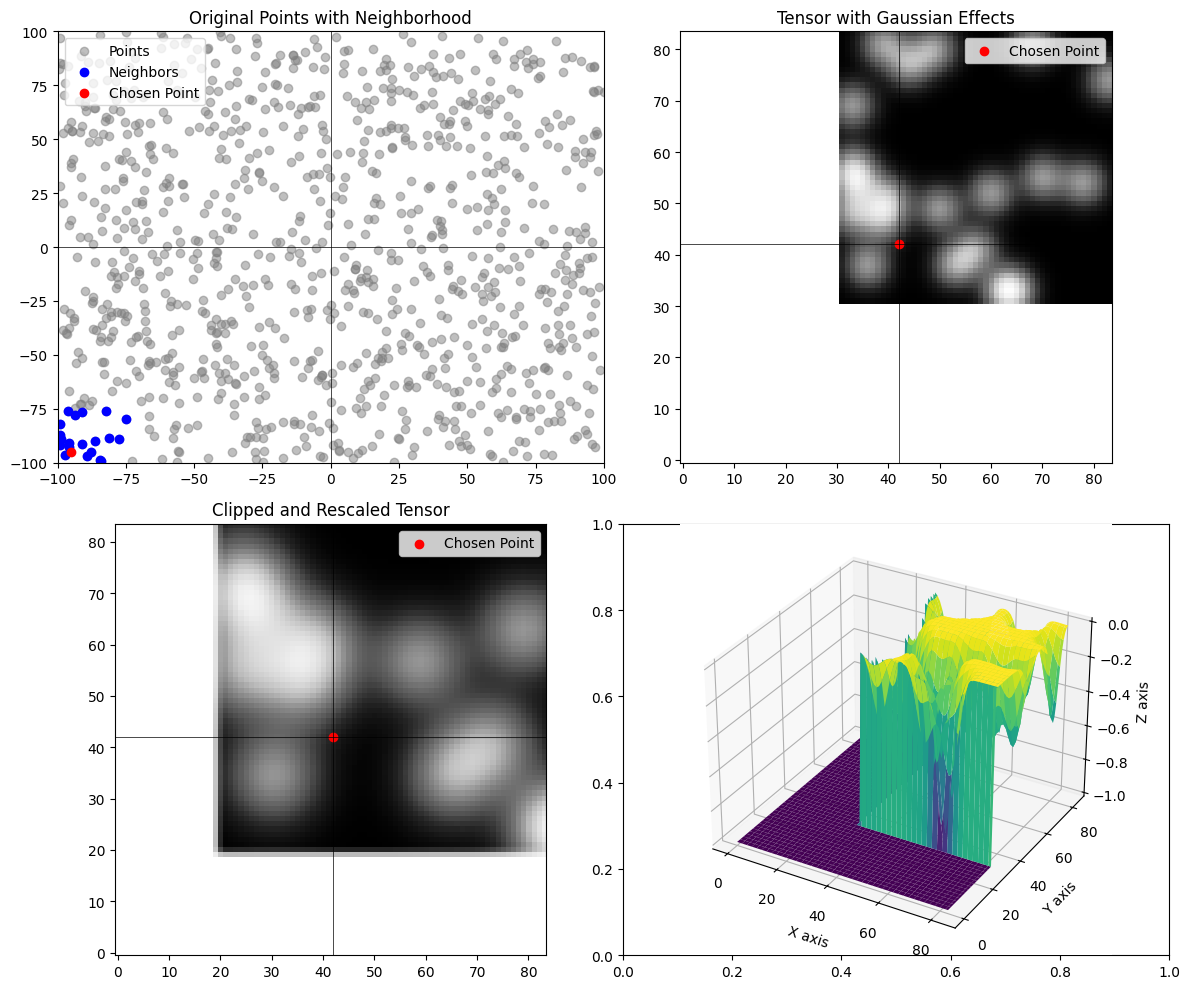

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

# Parameters
vicinity_limit = [20, 20]  # The vicinity limit around the chosen point (x, y)
tensor_size = [84, 84]     # The size of the final tensor (height, width)
sigma_scale = 3            # Scale for the Gaussian sigma relative to the initial space unit
negative_value = -1        # Value to fill the tensor edges

# Step 1: Generate random points
num_points = 1000
points = np.random.uniform(-100, 100, size=(num_points, 2))

# Step 2: Choose a random center point
center_point = [-95, -95]

# Step 3: Find neighboring points within the box limit of ±vicinity_limit
x_min, x_max = center_point[0] - vicinity_limit[0], center_point[0] + vicinity_limit[0]
y_min, y_max = center_point[1] - vicinity_limit[1], center_point[1] + vicinity_limit[1]

neighbors = points[
    (points[:, 0] >= x_min) & (points[:, 0] <= x_max) &
    (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
]

INITIAL_VALUE_TENSOR = 0
# Step 4: Project the points onto a centered NumPy array of shape (tensor_size[0], tensor_size[1])
tensor = np.full((tensor_size[0], tensor_size[1]), INITIAL_VALUE_TENSOR, dtype=np.float32)

# Normalize points to the centered tensor space
def to_tensor_space(point, center_point, tensor_size, vicinity_limit):
    x, y = point
    cx, cy = center_point
    # Normalize to [0, 1] range first
    x_normalized = (x - (cx - vicinity_limit[0])) / (2 * vicinity_limit[0])
    y_normalized = (y - (cy - vicinity_limit[1])) / (2 * vicinity_limit[1])
    # Convert to tensor space indices
    x_tensor = int(round(x_normalized * (tensor_size[1] - 1)))
    y_tensor = int(round(y_normalized * (tensor_size[0] - 1)))
    # Clamp indices to ensure they are within bounds
    x_tensor = np.clip(x_tensor, 0, tensor_size[1] - 1)
    y_tensor = np.clip(y_tensor, 0, tensor_size[0] - 1)
    return x_tensor, y_tensor

# Apply Gaussian distribution around each neighboring point on the tensor
def apply_distribution(field, position, sigma=10, amplitude=0.2, operation='add'):
    x, y = position
    grid_x, grid_y = np.meshgrid(
        np.arange(field.shape[1]), np.arange(field.shape[0]), indexing="ij"
    )
    gaussian = amplitude * np.exp(
        -((grid_x - x) ** 2 + (grid_y - y) ** 2) / (2 * sigma ** 2)
    )

    if operation == 'add':
        return field + gaussian
    elif operation == 'subtract':
        return field - gaussian
    elif operation == 'replace':
        mask = gaussian > 0
        field[mask] = gaussian[mask]
        return field
    else:
        raise ValueError("Invalid operation type. Use 'add', 'subtract', or 'replace'.")

# Apply Gaussian to each neighboring point, excluding the center point
for point in neighbors:
    if np.all(point == center_point):
        continue
    
    x_tensor, y_tensor = to_tensor_space(point, center_point, tensor_size, vicinity_limit)
    
    # Ensure the indices are within the bounds of the tensor
    if 0 <= x_tensor < tensor_size[1] and 0 <= y_tensor < tensor_size[0]:
        tensor = apply_distribution(tensor, (y_tensor, x_tensor), sigma=sigma_scale, amplitude=0.5, operation='subtract')
    else:
        print(f"Point {point} projected to out-of-bounds tensor coordinates ({x_tensor}, {y_tensor})")

# Fill tensor with the constant value outside the computed limits
limits = {
    "x_min": to_tensor_space([-100, center_point[1]], center_point, tensor_size, vicinity_limit)[0],
    "x_max": to_tensor_space([100, center_point[1]], center_point, tensor_size, vicinity_limit)[0],
    "y_min": to_tensor_space([center_point[0], -100], center_point, tensor_size, vicinity_limit)[1],
    "y_max": to_tensor_space([center_point[0], 100], center_point, tensor_size, vicinity_limit)[1]
}

tensor[:, :limits["x_min"]] = negative_value
tensor[:, limits["x_max"]+1:] = negative_value
tensor[:limits["y_min"], :] = negative_value
tensor[limits["y_max"]+1:, :] = negative_value

# Clip and resize the tensor
clip_size = [tensor_size[0] // 2, tensor_size[1] // 2]
start_x = tensor_size[1] // 2 - clip_size[1] // 2
start_y = tensor_size[0] // 2 - clip_size[0] // 2

clipped_tensor = tensor[start_y:start_y+clip_size[0], start_x:start_x+clip_size[1]]
rescaled_tensor = zoom(clipped_tensor, (tensor_size[0] / clip_size[0], tensor_size[1] / clip_size[1]), order=1)

# Plotting
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# Plot the original points and the chosen point
ax[0, 0].scatter(points[:, 0], points[:, 1], color='gray', alpha=0.5, label='Points')
ax[0, 0].scatter(neighbors[:, 0], neighbors[:, 1], color='blue', label='Neighbors')
ax[0, 0].scatter(center_point[0], center_point[1], color='red', label='Chosen Point')
ax[0, 0].axhline(0, color='black', linewidth=0.5)
ax[0, 0].axvline(0, color='black', linewidth=0.5)
ax[0, 0].set_xlim(-100, 100)
ax[0, 0].set_ylim(-100, 100)
ax[0, 0].legend()
ax[0, 0].set_title('Original Points with Neighborhood')

# Plot the tensor with Gaussian effects
ax[0, 1].imshow(tensor, cmap='Greys', origin='lower')
center_x, center_y = to_tensor_space(center_point, center_point, tensor_size, vicinity_limit)
ax[0, 1].scatter(center_x, center_y, color='red', label='Chosen Point')
ax[0, 1].axhline(center_y, color='black', linewidth=0.5)
ax[0, 1].axvline(center_x, color='black', linewidth=0.5)
ax[0, 1].set_title('Tensor with Gaussian Effects')
ax[0, 1].legend()

# Plot the clipped and rescaled tensor
ax[1, 0].imshow(rescaled_tensor, cmap='Greys', origin='lower')
center_x_rescaled, center_y_rescaled = tensor_size[1] // 2, tensor_size[0] // 2
ax[1, 0].scatter(center_x_rescaled, center_y_rescaled, color='red', label='Chosen Point')
ax[1, 0].axhline(center_y_rescaled, color='black', linewidth=0.5)
ax[1, 0].axvline(center_x_rescaled, color='black', linewidth=0.5)
ax[1, 0].set_title('Clipped and Rescaled Tensor')
ax[1, 0].legend()

# Plot the 3D surface plot
ax_3d = fig.add_subplot(2, 2, 4, projection='3d')

# Generate x and y coordinates
x = np.arange(tensor_size[1])  # Columns
y = np.arange(tensor_size[0])  # Rows
x, y = np.meshgrid(x, y)

# Plot the surface
ax_3d.plot_surface(x, y, tensor, cmap='viridis')

# Set labels
ax_3d.set_xlabel('X axis')
ax_3d.set_ylabel('Y axis')
ax_3d.set_zlabel('Z axis')

# Show the plots
plt.tight_layout()
plt.show()


## Hill Climbing

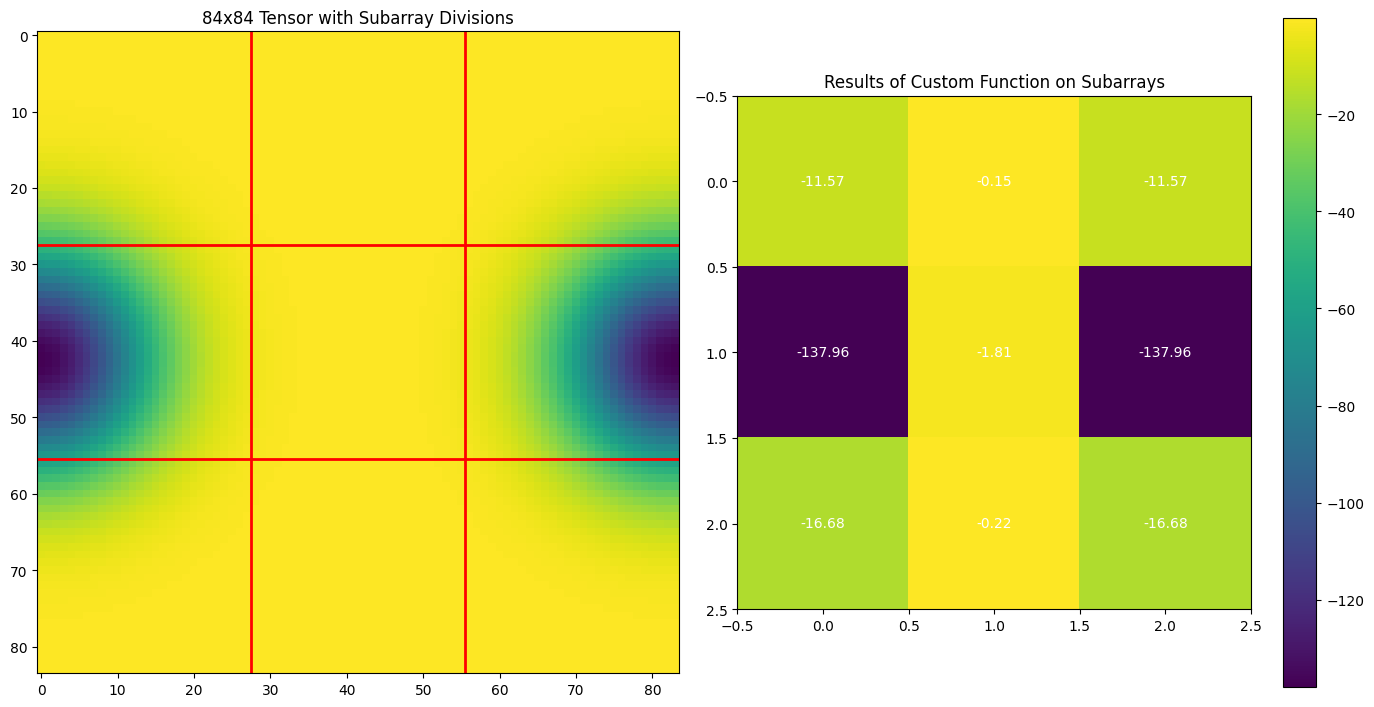

array([[ -11.57392979,   -0.15158844,  -11.57393074],
       [-137.95527649,   -1.80685616, -137.95527649],
       [ -16.68478966,   -0.21852742,  -16.68478966]])

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import gaussian_filter

# Define a custom function for Gaussian sum as an example
def gaussian_sum(arr, sigma=1):
    return np.sum(gaussian_filter(arr, sigma=sigma))

# Example custom function dictionary
custom_functions = {
    'sum': np.sum,
    'avg': np.mean,
    'min': np.min,
    'max': np.max,
    'gaussian_sum': gaussian_sum
}

def compute_subarray_results(arr, func_name='sum'):
    if func_name not in custom_functions:
        raise ValueError(f"Function {func_name} not recognized. Choose from {list(custom_functions.keys())}")

    func = custom_functions[func_name]
    nrows, ncols = arr.shape
    row_step = nrows // 3
    col_step = ncols // 3
    
    results = np.zeros((3, 3))
    
    for i in range(3):
        for j in range(3):
            subarray = arr[i*row_step:(i+1)*row_step, j*col_step:(j+1)*col_step]
            results[i, j] = func(subarray)
    
    return results

def plot_tensor_with_divisions(arr, ax):
    ax.imshow(arr, cmap='viridis', interpolation='none')
    ax.set_title('84x84 Tensor with Subarray Divisions')
    
    nrows, ncols = arr.shape
    row_step = nrows // 3
    col_step = ncols // 3
    
    for i in range(1, 3):
        ax.axhline(i * row_step - 0.5, color='red', linewidth=2)
        ax.axvline(i * col_step - 0.5, color='red', linewidth=2)

def plot_results(results, ax):
    cax = ax.imshow(results, cmap='viridis', interpolation='none', vmin=np.min(results), vmax=np.max(results))
    ax.set_title('Results of Custom Function on Subarrays')
    
    for (i, j), val in np.ndenumerate(results):
        ax.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
    
    plt.colorbar(cax, ax=ax)

# Example usage
np.random.seed(0)  # For reproducibility
# arr = np.random.rand(84, 84)  # Example 84x84 array
arr = rescaled_tensor
# Compute results
results = compute_subarray_results(arr, 'gaussian_sum')

# Create a 1x2 grid for plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Plot the original tensor with divisions
plot_tensor_with_divisions(arr, axes[0])

# Plot the results of the custom function
plot_results(results, axes[1])

plt.tight_layout()
plt.show()

results

## WIP

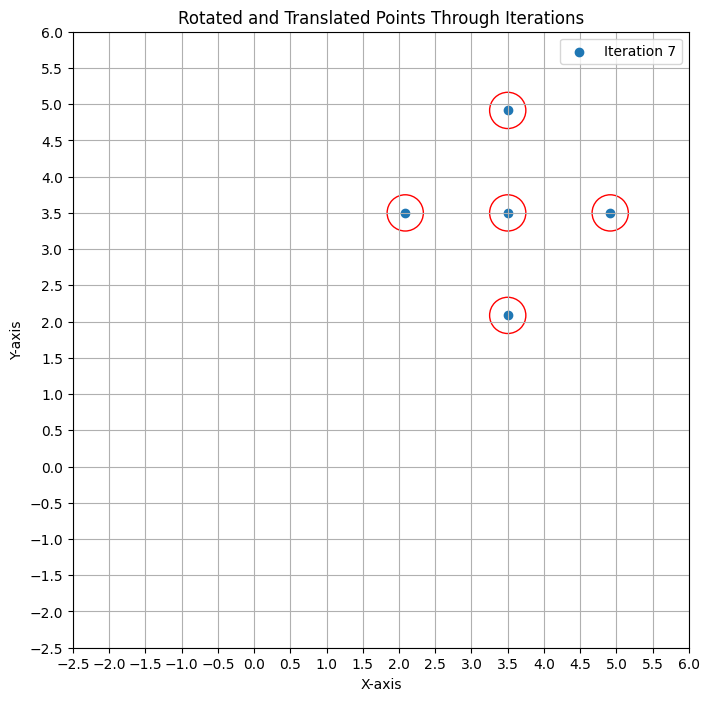

In [19]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_points(points, theta):
    # Convert theta to radians
    theta_rad = np.radians(theta)
    
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad), np.cos(theta_rad)]
    ])
    
    # Rotate each point
    rotated_points = np.dot(points, rotation_matrix.T)
    
    return rotated_points

def translate_points(points, translation_vector):
    # Translate each point by the translation vector
    translated_points = points + translation_vector
    
    return translated_points

# Define the points
points = np.array([[0, 0], [1, 1], [-1, 1], [1, -1], [-1, -1]])

# Define the rotation angle in degrees, the number of iterations, and the translation vector
theta = 45  # Rotation angle
iterations = 8  # Number of iterations
translation_vector = np.array([0.5, 0.5])  # Translation vector

# Plot the points for each iteration
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(iterations):
    if i != 7:
        continue
    rotated_points = rotate_points(points, theta * i)
    translated_points = translate_points(rotated_points, translation_vector * i)
    ax.scatter(translated_points[:, 0], translated_points[:, 1], label=f'Iteration {i}')
    for point in translated_points:
        ellipse = plt.Circle((point[0], point[1]), 0.25, edgecolor='r', fc='None', lw=1)
        ax.add_patch(ellipse)

# Set plot limits
ax.set_xlim(-2.5, 6)
ax.set_ylim(-2.5, 6)
ax.set_xticks(np.arange(-2.5, 6.5, 0.5))
ax.set_yticks(np.arange(-2.5, 6.5, 0.5))
ax.grid(True)
ax.set_aspect('equal')

# Add legend and labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Rotated and Translated Points Through Iterations')
plt.legend()
plt.show()


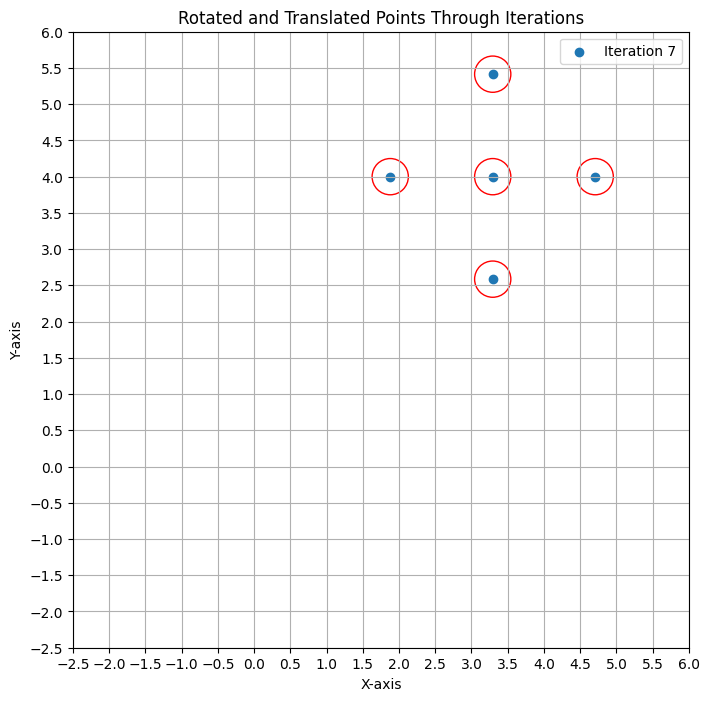

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def rotate_points(points, theta, center):
    # Convert theta to radians
    theta_rad = np.radians(theta)
    
    # Define the rotation matrix
    rotation_matrix = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad), np.cos(theta_rad)]
    ])
    
    # Translate points to the origin (subtract the center)
    translated_points = points - center
    
    # Rotate each point
    rotated_points = np.dot(translated_points, rotation_matrix.T)
    
    # Translate points back to the original center
    rotated_points += center
    
    return rotated_points

def translate_points(points, translation_vector):
    # Translate each point by the translation vector
    translated_points = points + translation_vector
    
    return translated_points

# Define the points
points = np.array([[0, 0], [1, 1], [-1, 1], [1, -1], [-1, -1]])

# Define the center of rotation
center_of_rotation = np.array([0.5, 0.5])  # Change this to your desired center

# Define the rotation angle in degrees, the number of iterations, and the translation vector
theta = 45  # Rotation angle
iterations = 8  # Number of iterations
translation_vector = np.array([0.5, 0.5])  # Translation vector

# Plot the points for each iteration
fig, ax = plt.subplots(figsize=(8, 8))

for i in range(iterations):
    if i != 7:
        continue
    rotated_points = rotate_points(points, theta * i, center_of_rotation)
    translated_points = translate_points(rotated_points, translation_vector * i)
    ax.scatter(translated_points[:, 0], translated_points[:, 1], label=f'Iteration {i}')
    for point in translated_points:
        ellipse = plt.Circle((point[0], point[1]), 0.25, edgecolor='r', fc='None', lw=1)
        ax.add_patch(ellipse)

# Set plot limits
ax.set_xlim(-2.5, 6)
ax.set_ylim(-2.5, 6)
ax.set_xticks(np.arange(-2.5, 6.5, 0.5))
ax.set_yticks(np.arange(-2.5, 6.5, 0.5))
ax.grid(True)
ax.set_aspect('equal')

# Add legend and labels
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Rotated and Translated Points Through Iterations')
plt.legend()
plt.show()
